In [1]:
from captum.attr import *
import torch
import torch.nn as nn
import pandas as pd
from json import load
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Liberation Serif'
matplotlib.rcParams['font.size'] = 15.0

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("COVIDiSTRESS_April_May_Combined.csv", encoding= 'unicode_escape')
df = df.drop(["Unnamed: 0", "1", "Uninformative response", "PSS10_avg"], axis="columns")
features = list(df.columns)

In [4]:
class StressNN(nn.Module):
    def __init__(self, input_size = 54):
        super(StressNN, self).__init__()
        self.LinBlock = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        x = self.LinBlock(x)
        x = torch.sigmoid(x)
        return x

In [5]:
model = StressNN(df.shape[1])
model.load_state_dict(torch.load("var/model_april_may_mse.pt"))
model = model.to(DEVICE)

In [6]:
svs = ShapleyValueSampling(model)

In [7]:
world = torch.from_numpy(df.to_numpy()).type(torch.FloatTensor).to(DEVICE)
f_imp = svs.attribute(world, target=0, show_progress=True).mean(axis=0).cpu()

Shapley Value Sampling attribution: 100%|██████████| 1351/1351 [00:24<00:00, 55.79it/s]


In [8]:
imp_df = pd.DataFrame().from_dict({
    "Features": features,
    "Importance": f_imp,
    "Absolute Importance": torch.abs(f_imp),
    "Direction": f_imp/torch.abs(f_imp)
})
imp_df.sort_values("Absolute Importance", inplace=True)
imp_df["Direction"] = imp_df["Direction"].apply(lambda x: "teal" if x==1 else "crimson")

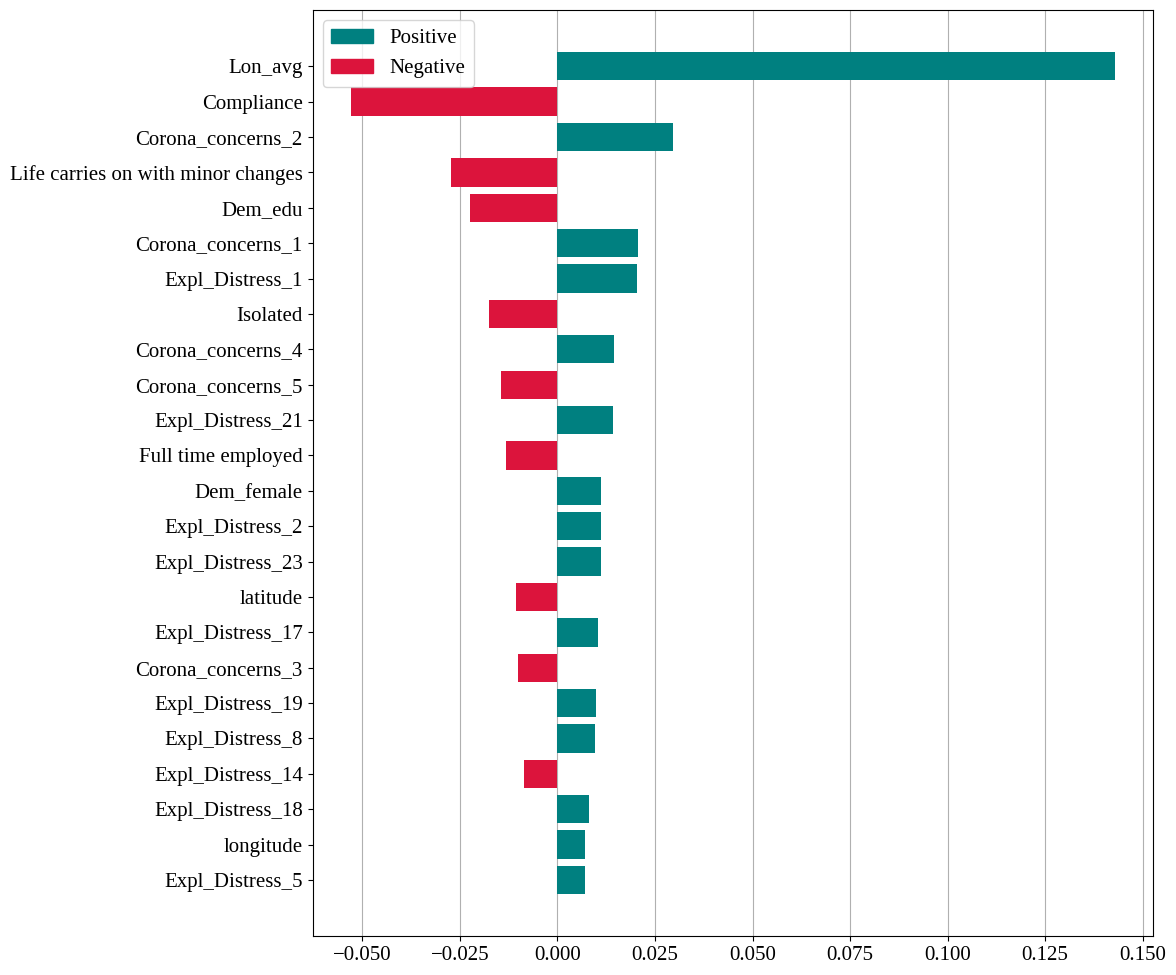

In [9]:
fig = plt.figure(figsize=(12, 10))
imp_df = imp_df.iloc[-24:, :]
plt.barh(imp_df["Features"], imp_df["Importance"], color=imp_df["Direction"], zorder=2)
plt.grid(axis="x", zorder=1, which="major")
plt.legend([plt.Rectangle((0,0),1,1, color="teal"), plt.Rectangle((0,0),1,1, color="crimson")], ["Positive", "Negative"])
plt.tight_layout()
plt.savefig("resources/world_importance_nn.png", dpi=300)
plt.show()

In [10]:
df["latitudex"] = df["latitude"]*1000
df["longitudex"] = df["longitude"]*1000
df["latitudex"] = df["latitudex"].apply(int)
df["longitudex"] = df["longitudex"].apply(int)

In [11]:
with open("country-codes-lat-long-alpha3.json", "r") as f:
    c_j = load(f)
country_df = pd.DataFrame().from_dict(c_j["ref_country_codes"]).loc[:, ["latitude", "longitude", "country"]]
country_df["latitudex"] = country_df["latitude"]/90.0*1000
country_df["longitudex"] = country_df["longitude"]/180.0*1000
country_df["latitudex"] = country_df["latitudex"].apply(int)
country_df["longitudex"] = country_df["longitudex"].apply(int)
country_df.drop(columns=["latitude", "longitude"], inplace=True)

In [12]:
df=df.merge(country_df, how="left", on=["latitudex", "longitudex"])
df.drop(columns=["latitudex", "longitudex"], inplace=True)
df

,latitude,longitude,Trust_countrymeasure,Lon_avg,Dem_age,Dem_edu,Dem_Expat,Dem_dependents,Dem_riskgroup,Corona_concerns_1,...,Self-employed,Student,Divorced/widowed,Married/cohabiting,Single,Isolated,Isolated in medical facility of similar location,Life carries on as usual,Life carries on with minor changes,country
0,0.622222,0.055556,0.5,0.466667,-0.416931,0.833333,1.0,0.000000,1.0,0.333333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Denmark
1,0.540741,0.108333,0.5,0.733333,0.989318,0.833333,0.0,0.000000,1.0,0.666667,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Slovakia
2,0.540741,0.108333,0.5,0.533333,0.619253,0.666667,0.0,0.582783,1.0,0.666667,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Slovakia
3,0.511111,0.011111,0.2,0.266667,0.545240,0.833333,0.0,0.321513,1.0,0.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,France
4,0.540741,0.108333,0.8,0.466667,1.581423,1.000000,0.0,0.000000,1.0,0.666667,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Slovakia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173009,0.622222,0.055556,0.6,0.466667,-0.786996,0.833333,1.0,0.000000,0.5,0.166667,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,Denmark
173010,0.622222,0.055556,0.4,0.466667,-0.416931,0.666667,1.0,0.000000,0.5,0.666667,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,Denmark
173011,0.622222,0.055556,0.4,0.266667,1.359384,0.500000,1.0,0.321513,1.0,0.500000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,Denmark
173012,0.622222,0.055556,0.8,0.333333,1.137345,0.666667,1.0,0.000000,0.5,0.500000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Denmark


In [13]:
for country in tqdm(df["country"].unique()):
    coun_df = df[df["country"]==country].drop(columns=["country"])
    coun = torch.from_numpy(coun_df.to_numpy()).type(torch.FloatTensor).to(DEVICE)
    f_imp_coun = svs.attribute(coun, target=0).mean(axis=0).cpu()

    imp_df_coun = pd.DataFrame().from_dict({
        "Features": features,
        "Importance": f_imp_coun,
        "Absolute Importance": torch.abs(f_imp_coun),
        "Direction": f_imp_coun/torch.abs(f_imp_coun)
    })
    imp_df_coun.sort_values("Absolute Importance", inplace=True)
    imp_df_coun["Direction"] = imp_df_coun["Direction"].apply(lambda x: "teal" if x==1 else "crimson")
    fig = plt.figure(figsize=(10, 12))
    
    imp_df_coun = imp_df_coun.iloc[-24:, :]
    plt.barh(imp_df_coun["Features"], imp_df_coun["Importance"], color=imp_df_coun["Direction"], zorder=2)
    plt.grid(axis="x", zorder=1, which="major")
    plt.legend([plt.Rectangle((0,0),1,1, color="teal"), plt.Rectangle((0,0),1,1, color="crimson")], ["Positive", "Negative"])
    plt.tight_layout()
    plt.savefig(f"resources/countries/{country}.png", dpi=300)
    plt.close()

100%|██████████| 159/159 [04:29<00:00,  1.70s/it]
